# Traget:
Build a Backpropagation neural network (BPNN) program to approximate the six-hump camelback function. The program needs to be written in Python language and use the Pytorch package
#### input: X, Y
#### output: Z

## BPNN

## import package

In [286]:
# !pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

In [287]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os

## Check GPU info.
ref: https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c

In [288]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [289]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

mps


## datasets
generate datasets from file: Hw04_2_generate_data.ipynb.

In [290]:
#  讀取數據
train_data = pd.read_csv('dataQ2/train.csv', header=None).values
valid_data = pd.read_csv('dataQ2/valid.csv', header=None).values
test_data = pd.read_csv('dataQ2/test.csv', header=None).values

# 將數據轉換成 PyTorch 張量
train_inputs = torch.from_numpy(train_data[:, :2]).float().to(device=device)
train_outputs = torch.from_numpy(train_data[:, 2:]).float().to(device=device)
valid_inputs = torch.from_numpy(valid_data[:, :2]).float().to(device=device)
valid_outputs = torch.from_numpy(valid_data[:, 2:]).float().to(device=device)
test_inputs = torch.from_numpy(test_data[:, :2]).float().to(device=device)
test_outputs = torch.from_numpy(test_data[:, 2:]).float().to(device=device)

print("train data shape:", train_data.shape)
print("valid data shape:", valid_data.shape)
print("test data shape:", test_data.shape)

train data shape: (700, 3)
valid data shape: (200, 3)
test data shape: (100, 3)


## model
ref: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [291]:
class BPNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BPNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU6(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU6(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU6(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU6(),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = self.layers(x).squeeze()
        return x


## parameter

In [292]:
# 設定模型參數
input_size = 2
hidden_size = 64
output_size = 1
learning_rate = 0.1
num_epochs = 100
batch = 4

In [293]:
# 使用TensorDataset和DataLoader進行批次讀取
train_dataset = TensorDataset(train_inputs, train_outputs)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_dataset = TensorDataset(valid_inputs, valid_outputs)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch, shuffle=True)

## loss and optimizer

In [294]:
# 建立 BPNN 模型
model = BPNN(input_size, hidden_size, output_size).to(device=device)

# 定義損失函數和優化器
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999)) ## momentum
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


## train

In [295]:
# 創建進度條
pbar = tqdm(total=num_epochs)

train_loss, valid_loss = [], [] # 紀錄loss
for epoch in range(num_epochs):
    for (x, target) in train_dataloader:
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # validation
    model.eval()

    for (x, target) in valid_dataloader:
        output = model(x)
        loss = criterion(output, target)
        valid_loss.append(loss.item())

    # 更新進度條的顯示信息
    pbar.set_postfix({'Train Loss': np.mean(train_loss), 'Valid Loss': np.mean(valid_loss)})
    pbar.update()

    # 更新學習率
    scheduler.step()

# 關閉進度條
pbar.close()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/linchenghao/Desktop/Master/01_Course/02_Intelligent_control/01_homework/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [01:49<00:00,  1.10s/it, Train Loss=58.8, Valid Loss=66.6]


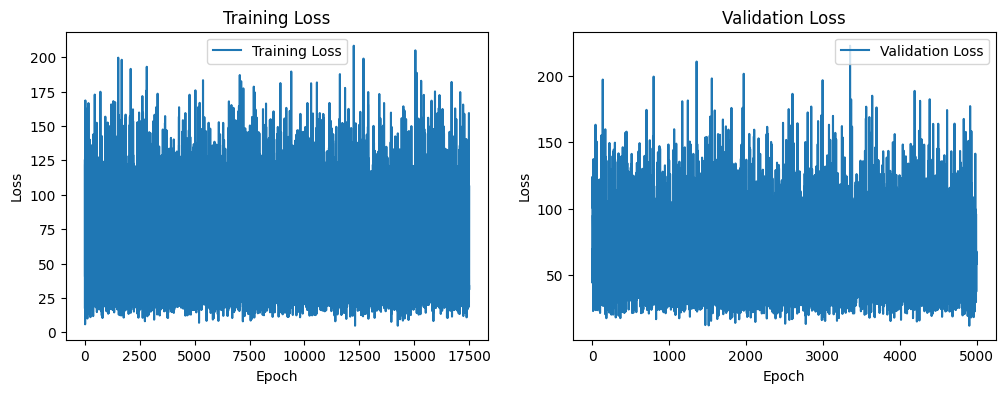

In [296]:
import matplotlib.pyplot as plt

# 繪製訓練集和驗證集的損失曲線
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(train_loss, label='Training Loss')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(valid_loss, label='Validation Loss')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

## test

In [297]:
# 在測試集上評估模型
with torch.no_grad():
    test_outputs_pred = model(test_inputs)
    test_loss = criterion(test_outputs_pred, test_outputs)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 62.1670


/Users/linchenghao/Desktop/Master/01_Course/02_Intelligent_control/01_homework/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [299]:
from tabulate import tabulate

# 在測試集上評估模型
with torch.no_grad():
    test_outputs_pred = model(test_inputs)
    test_loss = criterion(test_outputs_pred, test_outputs)
    print(f'Test Loss: {test_loss.item():.4f}')

    # 整理數據
    data = []
    for i in range(len(test_inputs[:10])):
        x1, x2, yd, yp = test_inputs[i][0], test_inputs[i][1], test_outputs[i], test_outputs_pred[i]
        loss = yd - yp
        row = [x1.item(), x2.item(), yd.item(), yp.item(), loss.item()]
        data.append(row)

    # 輸出表格
    headers = ["x1", "x2", "yd", "yp", "loss"]
    print(tabulate(data, headers=headers, floatfmt=".4f"))


Test Loss: 62.1670
     x1       x2        yd       yp      loss
-------  -------  --------  -------  --------
 1.0587  -0.6589    0.6344  39.4974  -38.8630
-2.4024  -0.9316   18.9986  39.6158  -20.6173
 1.1863  -1.4801   11.0770  39.5851  -28.5080
 2.3750   0.5557   16.0343  39.7372  -23.7028
 2.1777  -0.3962    5.8991  39.6822  -33.7831
 1.5894   1.5514   18.0892  39.7504  -21.6611
 1.0873   2.6448  172.9600  39.7881  133.1719
 0.6584  -2.5182  135.1911  39.6807   95.5104
 1.6921   1.2236    7.1086  39.7324  -32.6238
 1.0653   2.2019   79.3027  39.7753   39.5275
